Entrenar modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir con los siguientes puntos.
* Implementar la tubería de datos usando el conjunto de rostros alineados y recortados (https://cloud.xibalba.com.mx/s/sNcxdr2o7aeM7yF)
* Agregar acrecentamiento de datos usando un espejeo horizontal.
* Particionar aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %
* Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

In [24]:
!pip install torch-summary
!pip install wget

In [27]:
#importamos librerias utiles
#deep learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizer
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision.models as torchModels
#matrices y matematicas
import numpy as np
import pandas as pd
# tomar n elementos de una secuencia
from itertools import islice as take
#imagenes
from matplotlib import pyplot as plt
from PIL import Image
#descarga de archivos
import wget
#para acceder a ficheros del sistema
import os
import glob
#para descomprimir el archivo UTKFace.tar.gz
import tarfile

In [2]:
#para usar la GPU si esta disponible
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev)
print('Usando {}'.format(device))

Usando cuda:0


### Descargamos los datos

In [3]:
#wget.download('http://cloud.xibalba.com.mx/s/sNcxdr2o7aeM7yF/download','UTKFace.tar.gz')

### Extraemos las imagenes

In [4]:
#tar = tarfile.open('UTKFace.tar.gz', 'r:gz')
#tar.extractall()
#tar.close()
#carpeta = 'UTKFace'

Según https://susanqq.github.io/UTKFace/ cada imagen en el dataset de UTKFace viene nombrado como [age]\_[gender]\_[race]\_[date&time].jpg por lo que las etiquetas se encuentran autocontenidas en el mismo archivo. De esta forma es posible obtenerlas al leer el nombre de cada imagen

In [5]:
carpeta = 'UTKFace'
#funcion para extraer las edades de los archivos jpg
def getAges(carpeta):
    #funcion para extraer la edad de una sola imagen
    def getAgeIndividual(path):
        #guarda solo el nombre y extension de la imagen no la rauta y nombre
        fileName = os.path.split(path)[1]
        #guarda solo el nombre sin extension
        fileName = os.path.splitext(fileName)[0]
        #guarda la edad, que sera el primer elemento del nombre
        age = fileName.split('_')[0]
        # regresa la edad en forma de int
        return int(age)
    
    #define el path de todas las imagenes
    files = glob.glob(os.path.join(carpeta, '*.jpg'))
    #lista vacia para guardar las edades
    records = []
    #itera sobre todos los archivos
    for file in files:
        #usa la funcion de extraer edad para una sola imagen
        info = getAgeIndividual(file)
        #guarda la edad en la lista
        records.append(info)
    #define un dataframe de pandas con las edades    
    df = pd.DataFrame(records)
    #agrega una nueva columna al df de pandas llamada file con la ruta del archivo
    df['file'] = files
    #renombra la columna de edades a age
    df.columns = ['age', 'file']
    #tira a la basura valores NaN si es que existen en el df
    df = df.dropna()
    #regresa el df
    return df

In [6]:
#obtenemos el dataframe de edades y rutas de imagen
df = getAges(carpeta)
df.head(10)

,age,file
0,100,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1,100,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2,100,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3,100,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4,100,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg
5,100,UTKFace\100_1_0_20170112215032192.jpg.chip.jpg
6,100,UTKFace\100_1_0_20170117195420803.jpg.chip.jpg
7,100,UTKFace\100_1_0_20170119212053665.jpg.chip.jpg
8,100,UTKFace\100_1_2_20170105174847679.jpg.chip.jpg
9,100,UTKFace\100_1_2_20170112213615815.jpg.chip.jpg


In [7]:
#Hacemos un shuffle de una vez
df = df.sample(frac = 1).reset_index(drop=True)
df

,age,file
0,20,UTKFace\20_1_3_20170119153148521.jpg.chip.jpg
1,42,UTKFace\42_0_0_20170117135614403.jpg.chip.jpg
2,28,UTKFace\28_0_0_20170117180519102.jpg.chip.jpg
3,73,UTKFace\73_0_3_20170105180955031.jpg.chip.jpg
4,65,UTKFace\65_0_0_20170111203730182.jpg.chip.jpg
...,...,...
23703,63,UTKFace\63_0_0_20170113173302611.jpg.chip.jpg
23704,3,UTKFace\3_0_2_20161219142512185.jpg.chip.jpg
23705,26,UTKFace\26_0_1_20170116010639525.jpg.chip.jpg
23706,16,UTKFace\16_1_0_20170109213357694.jpg.chip.jpg


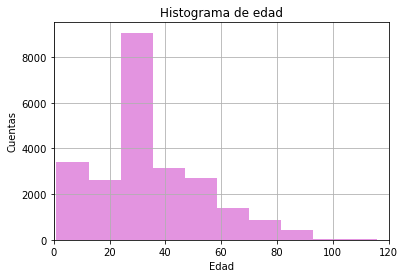

In [8]:
#graficando el histograma de edades
fig = plt.hist(df['age'], facecolor='orchid', alpha=0.75)
plt.xlabel('Edad')
plt.ylabel('Cuentas')
plt.title('Histograma de edad')
plt.xlim(0, 120)
plt.grid(True)
plt.show()

## Dividimos el dataset en entrenamiento y validacion
como el dataframe ya esta shufleado podemos tomar particiones del mismo para validacion y entrenamiento

In [9]:
#definimos el entero que corresponde al 80% de los datos
ochentaPorciento = int(len(df)*0.8)
#definimos el entero que corresponde al 20% de los datos se le suma uno porque me di cuenta que una imagen
#no entraba en ninguno de los dos conjuntos
veintePorciento = int(len(df)*0.2)+1
#print para verificar
print('El conjunto de entrenamiento consiste de {} imagenes, el 80% del mismo es {} mientras que el 20% es {}'.format(
    len(df), ochentaPorciento, veintePorciento))

#definimos el dataFrame de entrenamiento
trainDf = df[:ochentaPorciento]
#definimos el dataFrame de validacion
testDf = df[ochentaPorciento:]
#reseteamos los indices de ambos datasets
testDf =testDf.reset_index(drop=True)
trainDf = trainDf.reset_index(drop=True)

#print para verificar
print('la longitud de train es {}, mientras que test es {}'.format(trainDf.shape, testDf.shape))
#verifiquemos que el ultimo de train no este en el primero de test
print('La ruta de la ultima imagen de train es {}, y la ruta de la primer imagen de test es{}'.format(
    trainDf['file'][18965],testDf['file'][0]))

El conjunto de entrenamiento consiste de 23708 imagenes, el 80% del mismo es 18966 mientras que el 20% es 4742
la longitud de train es (18966, 2), mientras que test es (4742, 2)
La ruta de la ultima imagen de train es UTKFace\30_1_3_20170104214339133.jpg.chip.jpg, y la ruta de la primer imagen de test esUTKFace\27_1_0_20170103182420963.jpg.chip.jpg


In [10]:
testDf.to_csv('test.csv', index=False)
testDf

,age,file
0,27,UTKFace\27_1_0_20170103182420963.jpg.chip.jpg
1,26,UTKFace\26_1_4_20170117201855518.jpg.chip.jpg
2,26,UTKFace\26_1_1_20170116175425484.jpg.chip.jpg
3,27,UTKFace\27_0_1_20170117164520983.jpg.chip.jpg
4,41,UTKFace\41_0_0_20170113184511343.jpg.chip.jpg
...,...,...
4737,63,UTKFace\63_0_0_20170113173302611.jpg.chip.jpg
4738,3,UTKFace\3_0_2_20161219142512185.jpg.chip.jpg
4739,26,UTKFace\26_0_1_20170116010639525.jpg.chip.jpg
4740,16,UTKFace\16_1_0_20170109213357694.jpg.chip.jpg


In [11]:
testDf.to_csv('train.csv', index=False)
trainDf

,age,file
0,20,UTKFace\20_1_3_20170119153148521.jpg.chip.jpg
1,42,UTKFace\42_0_0_20170117135614403.jpg.chip.jpg
2,28,UTKFace\28_0_0_20170117180519102.jpg.chip.jpg
3,73,UTKFace\73_0_3_20170105180955031.jpg.chip.jpg
4,65,UTKFace\65_0_0_20170111203730182.jpg.chip.jpg
...,...,...
18961,56,UTKFace\56_1_0_20170120134758144.jpg.chip.jpg
18962,28,UTKFace\28_1_0_20170117180423496.jpg.chip.jpg
18963,32,UTKFace\32_1_1_20170114030326243.jpg.chip.jpg
18964,35,UTKFace\35_0_0_20170117190124521.jpg.chip.jpg


In [12]:
ss = pd.read_csv('train.csv')
ss

,age,file
0,27,UTKFace\27_1_0_20170103182420963.jpg.chip.jpg
1,26,UTKFace\26_1_4_20170117201855518.jpg.chip.jpg
2,26,UTKFace\26_1_1_20170116175425484.jpg.chip.jpg
3,27,UTKFace\27_0_1_20170117164520983.jpg.chip.jpg
4,41,UTKFace\41_0_0_20170113184511343.jpg.chip.jpg
...,...,...
4737,63,UTKFace\63_0_0_20170113173302611.jpg.chip.jpg
4738,3,UTKFace\3_0_2_20161219142512185.jpg.chip.jpg
4739,26,UTKFace\26_0_1_20170116010639525.jpg.chip.jpg
4740,16,UTKFace\16_1_0_20170109213357694.jpg.chip.jpg


## Creamos una clase UTKFaces de pytorch Dataset para nuestro conjunto de datos

In [13]:
class UTKFaces(Dataset):
    #init come el dataframe creado en celdas anteriores e incluimos la opcion de aplicar transformaciones
    def __init__(self, dataFrame, transform = None):
        #definimos las variables locales
        self.utkFacesFrame = pd.read_csv(dataFrame)
        self.transform = transform
    #funcion para determinar la longitud de nuestro dataset    
    def __len__(self):
        return len(self.utkFacesFrame)
    #funcion para regresar un elemento del dataset    
    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        #path a la imagen    
        imgName = self.utkFacesFrame['file'][idx]
        #abre la imagen
        image = Image.open(imgName)
        #si hay transformacion aplicala
        if self.transform is not None:
            image = self.transform(image)
        #abre la edad
        age = self.utkFacesFrame['age'][idx]
        #guarda en diccionario tanto la imagen como la edad
        sample = {'image': image, 'age':age}
        #regresa diccionario
        return sample

### Verificacion/Debug

In [14]:
#instancia el dataset
dataset = UTKFaces('train.csv')
#jala una muestra
sample = dataset[0]

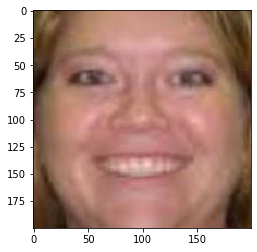

In [15]:
#checa imagen
plt.imshow(sample['image'])

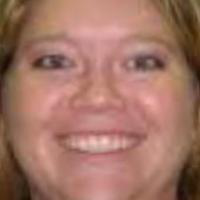

In [16]:
#checa el shape
sample['image']

In [17]:
#checa la edad
sample['age']

27

## Definimos las transformaciones

In [18]:
#Sembramos semilla aleatoria para reproducibilidad
torch.manual_seed(2021)
#creamos las transformaciones para el dataset de entrenamiento
transformForTrain = transforms.Compose([
    #redimensionamos al tamaño de ImageNet 224x224
    transforms.Resize(224),
    #dado que las imagenes son de 200x200 no es necario hacer centercrop
    #aplicamos modificacion aleatoria espejeo horizontal
    transforms.RandomHorizontalFlip(),
    #convertimos a tensor    
    transforms.ToTensor(),
    #normalizamos a la media y varianza de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Creamos las transformaciones para el dataset de validacion
transformForVal = transforms.Compose([
    #redimensionamos al tamaño de ImageNet 224x224
    transforms.Resize(224),
    #dado que las imagenes son de 200x200 no es necario hacer centercrop
    #convertimos a tensor    
    transforms.ToTensor(),
    #normalizamos a la media y varianza de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Instanciamos ambos datasets con sus respectivas transformaciones
trainDataset = UTKFaces('train.csv', transform = transformForTrain)
testDataset = UTKFaces('test.csv', transform = transformForVal)

## Funcion para ver imagenes

In [19]:
def showBatch(imLisst, titlesList, rows, cols):
    def showImages(imList, titlesList, rows, cols):
        #definimos un grid de imagenes 
        fig, ax = plt.subplots(rows, cols, figsize = (15,15))
        #auxiliar para poner las imagenes en su lugar
        counter = 0
        #itera sobre las filas
        for row in range(rows):
            #itera sobre las columnas
            for col in range(cols):
                #muestra la imagen en su posicion
                ax[row, col].imshow(imList[counter])
                ax[row, col].set_title(titlesList[counter])
                counter += 1
        #muestra el grid
        plt.show()
    #renormaliza, es decir pasa de valores entre 0 y 1 a valores de 0 a 256 (deshace la transformacion)    
    for c, (mean, std) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
        imLisst[:, c] = imLisst[:, c]* std + mean
    imLisst *= 255
    #cambia los canales
    imLisst = imLisst.permute(0,2,3,1)
    #pasalo a uint8
    imLisst = (imLisst.numpy()).astype(np.uint8)
    #usa la funcion de grid
    showImages(imLisst, titlesList, rows, cols)
    print('Done! ;)')

## Cargando datos

x shape=torch.Size([128, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


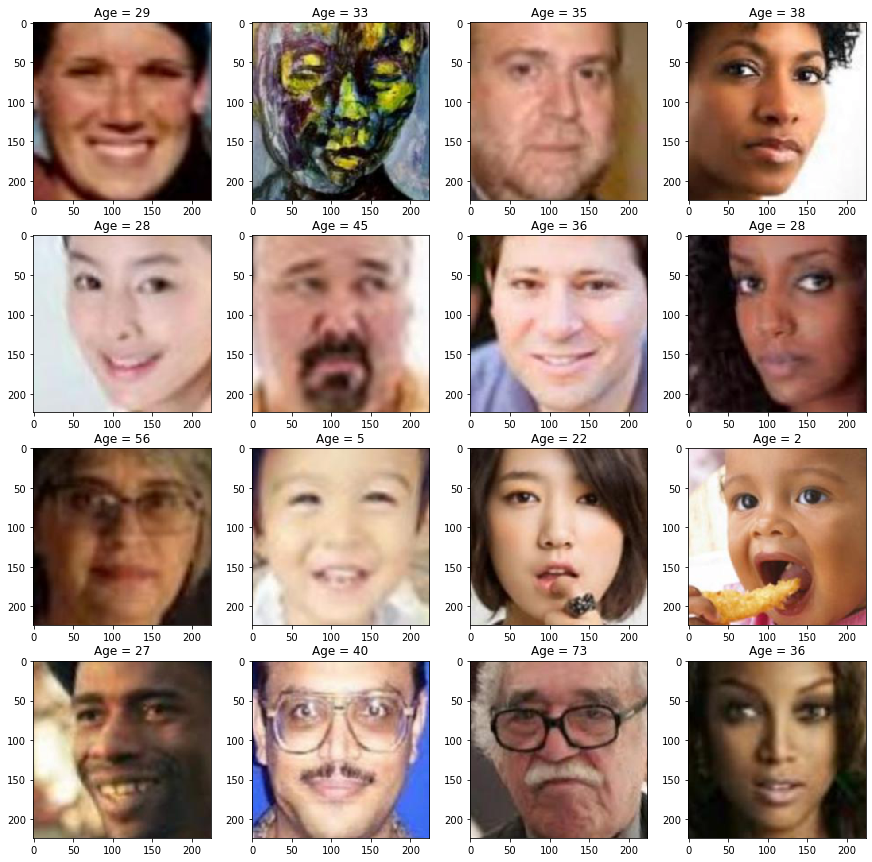

Done! ;)


In [20]:
#creamos el cargador de datos de entrenamiento con un tamaño de lote de 32, se hace shuffle.
#no usar otro numero de num_workers de cero porque si no no jala ¿Error de pytorch?
trainLoader = DataLoader(trainDataset, batch_size=128, shuffle=True, num_workers=0)

#mostramos las primeras 16 imagenes de un lote
lote = next(iter(trainLoader))
x, edades = lote['image'], lote['age']
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={edades.shape} dtype={edades.dtype}')
titles = [f'Age = {l}' for l in edades]
showBatch(x,titles,4,4)

x shape=torch.Size([128, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


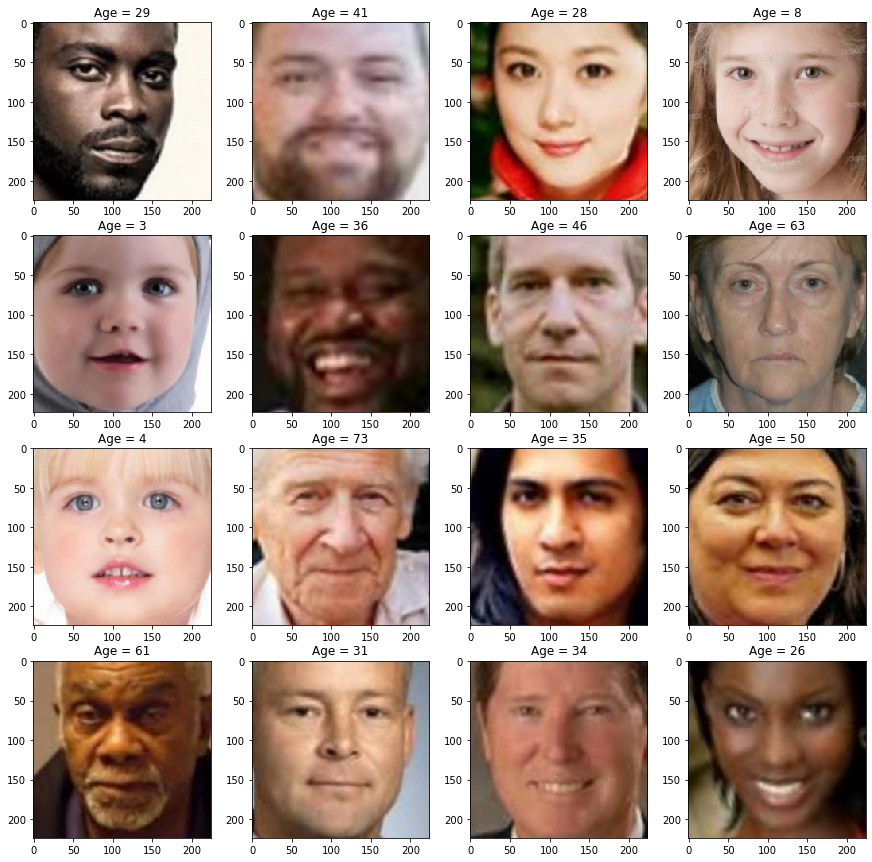

Done! ;)


In [21]:
#creamos el cargador de datos de entrenamiento con un tamaño de lote de 32, se hace shuffle.
#no usar otro numero de num_workers de cero porque si no no jala ¿Error de pytorch?
testLoader = DataLoader(testDataset, batch_size=128, shuffle=True, num_workers=0)

#mostramos las primeras 16 imagenes de un lote
lote = next(iter(trainLoader))
x, edades = lote['image'], lote['age']
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={edades.shape} dtype={edades.dtype}')
titles = [f'Age = {l}' for l in edades]
showBatch(x,titles,4,4)

## Carga del Modelo preentrenado

In [46]:
model = torchModels.squeezenet1_1(pretrained=True)
summary(model, (3, 224, 224), device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 13, 13]         --
|    └─Conv2d: 2-1                       [-1, 64, 111, 111]        1,792
|    └─ReLU: 2-2                         [-1, 64, 111, 111]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 55, 55]          --
|    └─Fire: 2-4                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 55, 55]          1,040
|    |    └─ReLU: 3-2                    [-1, 16, 55, 55]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 55, 55]          1,088
|    |    └─ReLU: 3-4                    [-1, 64, 55, 55]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 55, 55]          9,280
|    |    └─ReLU: 3-6                    [-1, 64, 55, 55]          --
|    └─Fire: 2-5                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-7                  [-1, 16, 55, 55]          2,064


In [44]:
#squeezenet1_1
summary(model, (3, 224, 224), 
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 13, 13]         --
|    └─Conv2d: 2-1                       [-1, 64, 111, 111]        1,792
|    └─ReLU: 2-2                         [-1, 64, 111, 111]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 55, 55]          --
|    └─Fire: 2-4                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 55, 55]          1,040
|    |    └─ReLU: 3-2                    [-1, 16, 55, 55]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 55, 55]          1,088
|    |    └─ReLU: 3-4                    [-1, 64, 55, 55]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 55, 55]          9,280
|    |    └─ReLU: 3-6                    [-1, 64, 55, 55]          --
|    └─Fire: 2-5                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-7                  [-1, 16, 55, 55]          2,064
